# 한글 Word2Vec 만들기
- 한글로 된 코퍼스를 다운받아 전처리를 수행
- 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 41.7MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

### 훈련 데이터 전처리하기


In [3]:
# 네이버 영화평 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fb720321390>)

In [4]:
!ls -l

total 19064
-rw-r--r-- 1 root root 19515078 Feb 24 01:13 ratings.txt
drwxr-xr-x 1 root root     4096 Feb 22 14:38 sample_data


In [5]:
train_df = pd.read_table('ratings.txt')
train_df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1


In [6]:
train_df.shape

(200000, 3)

In [7]:
# 중복 여부 확인
train_df['document'].nunique()

194543

In [8]:
# 중복 샘플 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
train_df.shape

(194544, 3)

In [9]:
# Null값 확인
train_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [10]:
# Null값 제거
train_df = train_df.dropna(how = 'any')
train_df.shape

(194543, 3)

In [11]:
# 정규 표현식을 통한 한글 외 문자 제거
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1


In [12]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [13]:
# 한글 형태소 분석
import tqdm.notebook as tn
okt = Okt()

tokenized_data =[]
for sentence in tn.tqdm(train_df['document']):
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.968572500681084


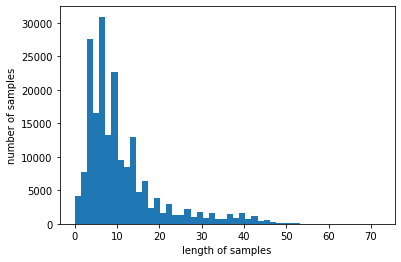

In [14]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :', max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :', sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Word2Vec 훈련시키기
- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram

In [15]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=tokenized_data, size=100, window=5, min_count=5, workers=4, sg=0)

In [16]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16466, 100)

In [17]:
model_result = model.wv.most_similar("최민식")
model_result

[('안성기', 0.861579418182373),
 ('유다인', 0.837981104850769),
 ('임원희', 0.8353631496429443),
 ('한석규', 0.8351044654846191),
 ('채민서', 0.8275743722915649),
 ('박중훈', 0.8189702033996582),
 ('송강호', 0.8173131942749023),
 ('양동근', 0.8154677152633667),
 ('김갑수', 0.8104804158210754),
 ('크로우', 0.8092832565307617)]

In [18]:
model_result = model.wv.most_similar("히어로")
model_result

[('호러', 0.8847255110740662),
 ('슬래셔', 0.8810478448867798),
 ('무협', 0.8802111148834229),
 ('느와르', 0.8597334027290344),
 ('정통', 0.8339824676513672),
 ('블록버스터', 0.8278623819351196),
 ('최고봉', 0.8141956329345703),
 ('무비', 0.8135253190994263),
 ('홍콩', 0.8123382329940796),
 ('블랙', 0.8083032369613647)]

In [19]:
!ls -l

total 19064
-rw-r--r-- 1 root root 19515078 Feb 24 01:13 ratings.txt
drwxr-xr-x 1 root root     4096 Feb 22 14:38 sample_data
